In [140]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ast
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import pmdarima as pm
from sklearn.model_selection import train_test_split
from statsmodels.stats.diagnostic import acorr_ljungbox
from scipy.stats import probplot
from pmdarima.metrics import smape
from sklearn.metrics import mean_absolute_error

In [87]:
train_route = 20
station = 19

In [88]:
data = pd.read_csv('Data/Cleaned_data.csv')

In [89]:
dates = pd.to_datetime(data[(data['visualiseringskode'] == train_route) & (data['station'] == station)]['dato'].values)
y = data[(data['visualiseringskode'] == train_route) & (data['station'] == station)]['togpunktlighed'].values

# Stationarity Check

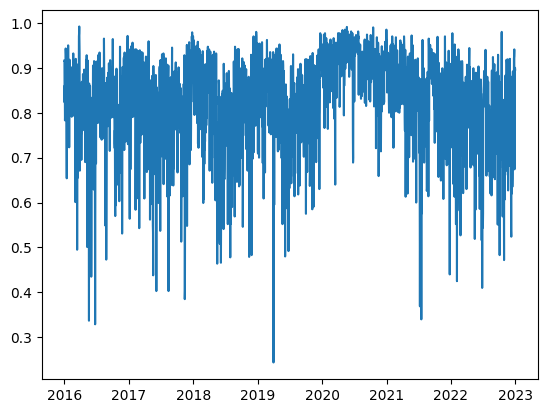

In [91]:
# Inspect time series plot for trend or seasonality
plt.plot(dates, y)
plt.show()

In [93]:
# Augmented Dickey-Fuller (ADF) 
result = adfuller(y)

In [96]:
# Result stats
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:', result[4])

# Result interpretation
if result[1] <= 0.05:
    print("Reject the null hypothesis. The time series is stationary.")
else:
    print("Fail to reject the null hypothesis. The time series is non-stationary.")

ADF Statistic: -4.2925844939263795
p-value: 0.00045753189592791287
Critical Values: {'1%': -3.432938355012086, '5%': -2.8626835272597217, '10%': -2.567378742868999}
Reject the null hypothesis. The time series is stationary.


Great it is stationary - but still uses integration order = 1 later?

# Autocorrelation (ACF) and Partial Autocorrelation (PACF)

The ACF plot helps determine the MA order (q), while the PACF plot helps determine the AR order (p). Subjective methods.
Spikes in the ACF plot indicate potential autoregressive (AR) terms, while spikes in the PACF plot indicate potential moving average (MA) terms.

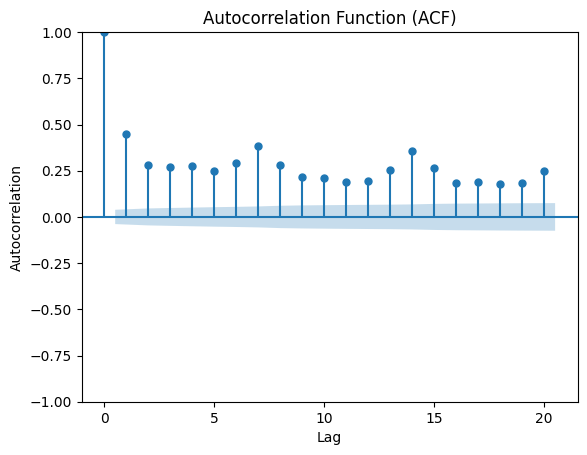

In [102]:
# Plot ACF
plot_acf(y, lags=20)
plt.title('Autocorrelation Function (ACF)')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.show()

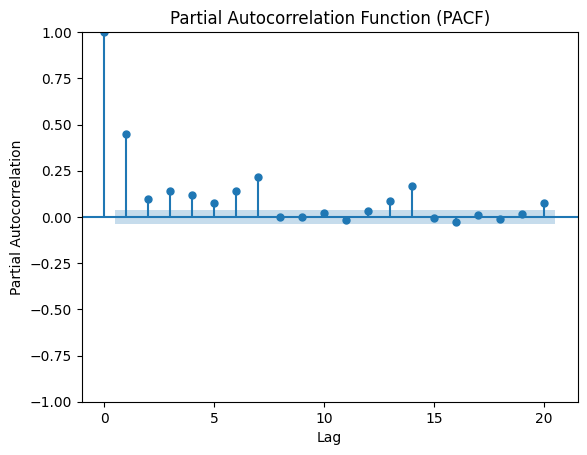

In [103]:
# Plot PACF
plot_pacf(y, lags=20)
plt.title('Partial Autocorrelation Function (PACF)')
plt.xlabel('Lag')
plt.ylabel('Partial Autocorrelation')
plt.show()

Spikes at specific lags indicate that there might be significant correlation between observations at those time intervals. High weekly correlation. This could hint towards seasonality. There is a pattern in the data!

# Model fitting + forecasting

In [224]:
best_model_params = pd.read_csv('Data/Best_model_parameters_SARIMA_strækning_station.csv')

In [225]:
best_arima_params = ast.literal_eval(best_model_params[best_model_params['Key'] == str((int(train_route), int(station)))]['Values'].values[0])

In [227]:
best_arima_params #= [(6, 1, 7), (0, 0, 0, 0)]

In [228]:
arima_model = pm.arima.ARIMA(order = best_arima_params[0], seasonal_order=best_arima_params[1])

In [229]:
y_train, y_test = train_test_split(y, test_size=365, shuffle=False)

In [230]:
def forecast_one_step(model, y_train):
    model.fit(y_train)
    fc, conf_int = model.predict(n_periods=1, return_conf_int=True)
    return (
        fc.tolist()[0],
        np.asarray(conf_int).tolist()[0])

In [231]:
y_train

array([0.916, 0.916, 0.823, ..., 0.813, 0.752, 0.758])

In [234]:
forecasts = []
confidence_intervals = []

for new_ob in y_test:
    fc, conf = forecast_one_step(arima_model, y_train)
    forecasts.append(fc)
    confidence_intervals.append(conf)

    y_train = np.append(y_train, new_ob)
    # Updates the existing model with a small number of steps


/Users/clarasofiechristiansen/anaconda3/envs/DSB_Bachelorprojekt/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/clarasofiechristiansen/anaconda3/envs/DSB_Bachelorprojekt/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/clarasofiechristiansen/anaconda3/envs/DSB_Bachelorprojekt/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/clarasofiechristiansen/anaconda3/envs/DSB_Bachelorprojekt/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimiza

In [235]:
residuals = forecasts - y_test

## Ljung-Box Test

In [215]:
# Ljung-Box test
lags = 20  # Specify the number of lags to test
test_results = acorr_ljungbox(residuals, lags=lags)

In [216]:
test_results

,lb_stat,lb_pvalue
1,0.238397,6.253661e-01
2,0.238763,8.874693e-01
3,2.167614,5.383556e-01
4,5.950637,2.028652e-01
5,6.227759,2.846836e-01
6,7.053057,3.159684e-01
7,22.922223,1.758587e-03
8,23.237115,3.072790e-03
9,30.369607,3.794936e-04
10,34.330792,1.623160e-04


In [217]:
# Result stats
print("Ljung-Box test statistics:", test_results['lb_stat'])
print("p-values:", test_results['lb_pvalue'])

# Result interpretation
for lag, p_value in zip(range(1, lags + 1), test_results['lb_pvalue']):
    if p_value < 0.05:
        print(f"Lag {lag}: Reject the null hypothesis (significant autocorrelation)")
    else:
        print(f"Lag {lag}: Fail to reject the null hypothesis (no significant autocorrelation)")

Ljung-Box test statistics: 1      0.238397
2      0.238763
3      2.167614
4      5.950637
5      6.227759
6      7.053057
7     22.922223
8     23.237115
9     30.369607
10    34.330792
11    34.474308
12    40.246795
13    46.692650
14    55.046522
15    55.440986
16    64.206883
17    64.264176
18    65.505198
19    67.255660
20    67.753277
Name: lb_stat, dtype: float64
p-values: 1     6.253661e-01
2     8.874693e-01
3     5.383556e-01
4     2.028652e-01
5     2.846836e-01
6     3.159684e-01
7     1.758587e-03
8     3.072790e-03
9     3.794936e-04
10    1.623160e-04
11    3.024241e-04
12    6.543100e-05
13    1.088711e-05
14    8.500095e-07
15    1.505472e-06
16    1.008141e-07
17    2.044754e-07
18    2.562554e-07
19    2.613399e-07
20    4.220055e-07
Name: lb_pvalue, dtype: float64
Lag 1: Fail to reject the null hypothesis (no significant autocorrelation)
Lag 2: Fail to reject the null hypothesis (no significant autocorrelation)
Lag 3: Fail to reject the null hypothesis (no signi

There exist significant autocorrelation which can either be modelled by AR or MA.
It suggests that the model have (probably) effectively accounted for autocorrelation up to lag 9, but not at higher lacks where the residual autocorrelations is still high. This may indicate that the model could be improved, potentially by incorporating additional terms or adjusting the model parameters to better capture the temporal structure of the data. 

# Residual Analysis

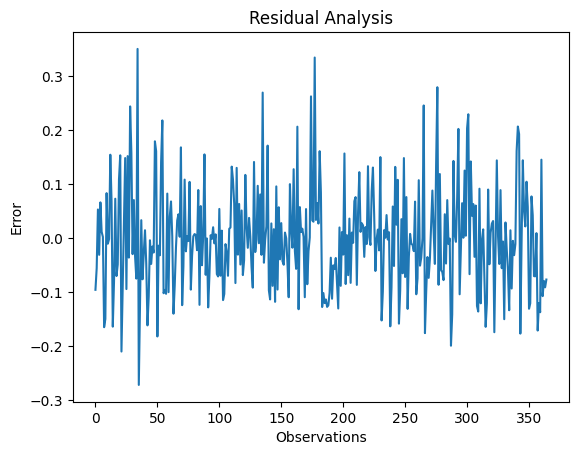

In [218]:
# Visual Analysis
plt.plot(residuals)
plt.title('Residual Analysis')
plt.xlabel('Observations')
plt.ylabel('Error')
plt.show()

In [219]:
# Descriptive Statistic Analysis
print(f'Mean: {np.mean(residuals)}')
print(f'Variance: {np.var(residuals)}')


Mean: -0.0015149010612054274
Variance: 0.009401727939054586


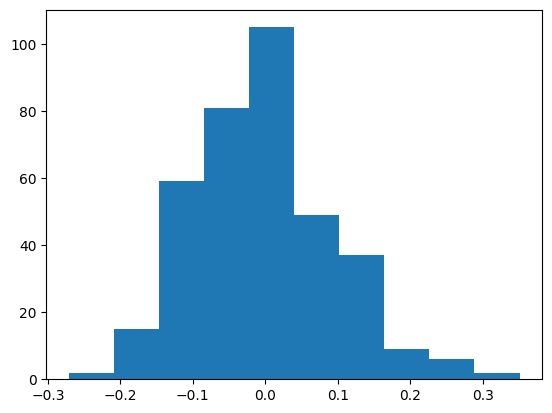

In [220]:
# To check for skewedness - a little bit
plt.hist(residuals)
plt.show()

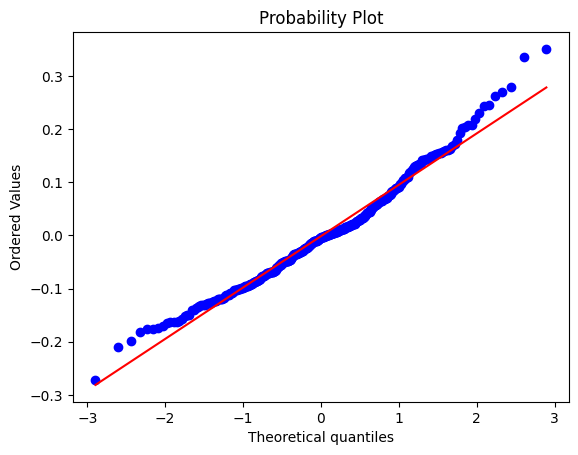

In [221]:
# Check if residuals follow a normal distribution
probplot(residuals, dist="norm", plot=plt)
plt.show()

The ultimative test: Does it work on unseen data. 

In [236]:
# Test
print(f"Mean absolute error: {mean_absolute_error(y_test, forecasts)}")
print(f"SMAPE: {smape(y_test, forecasts)}")

Mean absolute error: 0.07164165093568045
SMAPE: 9.482679841150459


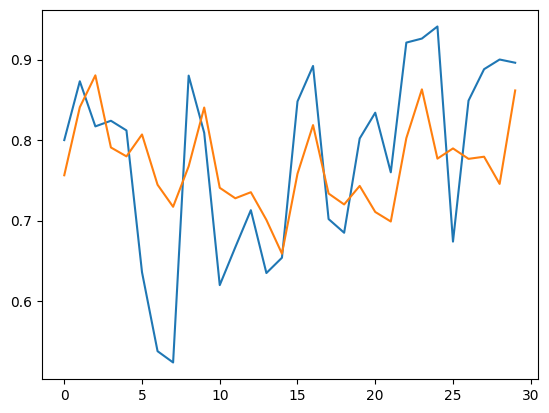

In [237]:
plt.plot(y_test[-30:])
plt.plot(forecasts[-30:])

In [246]:
for i, j in data[['visualiseringskode', 'station']].drop_duplicates().values:
    
    print(f'[{int(i)},{int(j)}],')

[2,0],
[2,2],
[9,2],
[10,3],
[24,3],
[21,4],
[10,5],
[8,5],
[11,6],
[13,6],
[9,6],
[2,8],
[20,9],
[17,11],
[5,12],
[5,13],
[6,13],
[7,13],
[19,14],
[17,15],
[11,16],
[19,17],
[20,17],
[21,17],
[27,17],
[23,18],
[20,19],
[15,20],
[16,20],
[2,21],
[3,21],
[18,22],
[23,22],
[25,22],
[25,23],
[13,24],
[15,24],
[13,25],
[14,25],
[20,26],
[11,27],
[24,28],
[14,29],
[16,31],
[18,31],
[27,31],
[16,33],
[17,33],
[19,33],
[6,34],
[9,34],
[12,35],
[16,36],
[7,37],
[8,37],
[6,38],
[3,39],
[4,39],
[5,39],
[14,40],
[24,41],
[11,42],
[12,42],
[4,43],
[8,44],
[3,45],
[5,46],
[9,46],
[25,47],


In [248]:
data[['visualiseringskode', 'station']].drop_duplicates().values.shape

(69, 2)

In [249]:
69*2

138